In [1]:
import os
import tqdm
import torch
import random
import numpy as np
# import albumentations as A
import torch.nn.functional as F 
import matplotlib.pyplot as plt
import torch.version

from typing import Tuple
from torch import nn, optim
from dataclasses import dataclass
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [2]:
def print_pytorh_and_cuda():
    print("PyTorch version:", torch.__version__)
    print("CUDA available:", torch.cuda.is_available())
    print("CUDA version (PyTorch built with):", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())

    if torch.cuda.is_available():
        print("\n--- GPU Info ---")
        print("GPU name:", torch.cuda.get_device_name(0))
        print("Current device index:", torch.cuda.current_device())
        print("Device capability:", torch.cuda.get_device_capability(0))
        print("Memory allocated:", torch.cuda.memory_allocated(0) / 1024**2, "MB")
        print("Memory reserved:", torch.cuda.memory_reserved(0) / 1024**2, "MB")
        !nvidia-smi
    else: print("CUDA none")

print_pytorh_and_cuda()

PyTorch version: 2.8.0+cpu
CUDA available: False
CUDA version (PyTorch built with): None
cuDNN version: None
CUDA none


In [4]:
@dataclass
class TrainConfig():
    # Воспроизводимость
    seed: int = 0
    
    # Данные
    batch_size: int = 32
    do_shuffle_train: bool = True
    img_size: int = 28
    ratio_train_val_test: tuple[float, float, float] = (.8, .1, .1)
    
    # Модель
    hidden_dim: int = 64
    p_dropout: float = .3
    n_classes: int = 10
    
    # Обучение
    n_epochs: int = 100
    lr: float = 1e-5
    eval_every: int = 2000 # ???
    
    # Оптимизация
    num_workers: int = 12
    weight_decay: float = 1e-5
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
def fix_seeds(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.mps.manual_seed(seed)
    
def enable_determinism():
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
    torch.use_deterministic_algorithms(True)

In [5]:
config = TrainConfig(
    seed = 0,
    ###
    batch_size = 512, 
    do_shuffle_train = True,
    img_size = 28,
    ratio_train_val_test = (.8, .1, .1),
    ###
    hidden_dim = 64,
    p_dropout = .3,
    n_classes = 10,
    ###
    n_epochs = 10,
    lr = 0.001,
    eval_every = 2000,
    ###
    num_workers = 0,
    weight_decay = 1e-5,
    device = torch.device("cpu"),
)
enable_determinism()
fix_seeds(config.seed)

In [6]:
# свой класс датасета
# class ThisDataset(datasets): 

In [7]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

generator = torch.Generator()
generator.manual_seed(config.seed)

train_dataset, valid_dataset = random_split(
    dataset = datasets.MNIST(
        root='./data',
        train=True, 
        download=True,
        transform=transform
    ),
    lengths = [config.ratio_train_val_test[0], config.ratio_train_val_test[1] + config.ratio_train_val_test[2]],
    generator = generator,
)

test_dataset = datasets.MNIST(
    root='./data',
    train=False, 
    download=True,
    transform=transform
),
test_dataset = test_dataset[0]

def seed_worker(_):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=config.do_shuffle_train,
    generator=generator,
    drop_last=True,
    num_workers=config.num_workers,
    pin_memory=True,
    worker_init_fn=seed_worker
)

valid_loader = DataLoader(
    valid_dataset, 
    batch_size=config.batch_size, 
    shuffle=False, 
    drop_last=True,
    num_workers=config.num_workers,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config.batch_size, 
    shuffle=False, 
    pin_memory=True
)

In [ ]:
class MnistNN(nn.Module):
    def __init__(self, cfg: TrainConfig):
        super().__init__()
        self.img_size = cfg.img_size
        self.hidden_dim = cfg.hidden_dim
        self.n_classes = cfg.n_classes
        self.net = nn.Sequential(
            # nn.Flatten(start_dim=1),
            nn.Linear(self.img_size * self.img_size, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, self.hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim // 2, self.hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(self.hidden_dim // 4, self.n_classes),
            nn.Softmax()
        )

    def forward(self, x):
        x = x.reshape((x.shape[0], -1))
        return self.net(x)
    
model = MnistNN(config)
model.to(config.device)
x, y = next(iter(train_loader))
x, y = x.to(config.device), y.to(config.device)
print(x.shape)
print(model(x).shape)

torch.Size([512, 1, 28, 28])
torch.Size([512, 10])


c:\Users\grish\OneDrive\Desktop\PythonPortable\_env\desk\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
def start_train(
    mdl: MnistNN, 
    cfg: TrainConfig, 
    trn_ldr: DataLoader,
    val_ldr: DataLoader
) -> list[Tuple[int, float]]:
    
    mdl.to(config.device)
    optm = optim.Adam(
        mdl.parameters(), 
        lr=cfg.lr, 
        weight_decay=cfg.weight_decay
    )
    mdl.train()
    print(f"Model on: {next(mdl.parameters()).device}")
    train_losses: list[Tuple[int, float]] = []

    for epoch in range(cfg.n_epochs + 1):
        print(f"Epoch ( {epoch} )")
        running_loss = 0.0
        for i, (x_batch, y_batch) in enumerate(tqdm.tqdm(trn_ldr)):
            optm.zero_grad()
            x_batch, y_batch = x_batch.to(cfg.device), y_batch.to(cfg.device)
            pred = mdl(x_batch)
            loss = F.cross_entropy(pred, y_batch)
            loss.backward()
            optm.step()
            # print(f"x_batch, y_batch on: {x_batch.device}--{y_batch.device}")
            # print(f"pred on: {pred.device}")
            # print(f"loss on: {loss.device}")
            running_loss += loss.cpu().item()
            # шедуллер

        epoch_loss = running_loss / len(trn_ldr)
        train_losses.append((epoch, epoch_loss))
        print(f"( {epoch} ) Average train loss: {epoch_loss:.4f}")
    
    return train_losses

In [ ]:
def strat_eval(model: nn.Module, device: torch.device, loader: DataLoader) -> list[Tuple[int, float]]:
    model.eval()
    inference_losses: list[Tuple[int, float]] = []
    counter = 0
    with torch.no_grad():
        for x_batch, y_batch in loader:
            x_batch: torch.Tensor = x_batch.to(device)
            y_batch: torch.Tensor = y_batch.to(device)
            pred: torch.Tensor = model(x_batch)
            loss: torch.Tensor = F.cross_entropy(pred, y_batch)
            loss.add(loss.cpu().item())
            inference_losses.append((counter, loss.detach().item()))
            counter+=1

    avg_infer_loss = sum(np.array(inference_losses)[:, 1]) / len(inference_losses)
    print(f"Average inference loss: {avg_infer_loss:.4f}")
    
    return inference_losses

In [11]:
train_losses = start_train(model, config, train_loader, valid_loader)
torch.save(model.state_dict(), 'mnist_model.pth')

Model on: cpu


100%|██████████| 93/93 [00:14<00:00,  6.29it/s]


( 0 ) Average train loss: 1.4521


100%|██████████| 93/93 [00:14<00:00,  6.53it/s]


( 1 ) Average train loss: 0.9005


100%|██████████| 93/93 [00:14<00:00,  6.20it/s]


( 2 ) Average train loss: 0.6906


100%|██████████| 93/93 [00:16<00:00,  5.79it/s]


( 3 ) Average train loss: 0.5646


100%|██████████| 93/93 [00:17<00:00,  5.43it/s]


( 4 ) Average train loss: 0.5012


100%|██████████| 93/93 [00:17<00:00,  5.32it/s]


( 5 ) Average train loss: 0.4561


100%|██████████| 93/93 [00:17<00:00,  5.29it/s]


( 6 ) Average train loss: 0.4287


100%|██████████| 93/93 [00:17<00:00,  5.30it/s]


( 7 ) Average train loss: 0.4003


100%|██████████| 93/93 [00:17<00:00,  5.29it/s]


( 8 ) Average train loss: 0.3870


100%|██████████| 93/93 [00:17<00:00,  5.28it/s]


( 9 ) Average train loss: 0.3698


100%|██████████| 93/93 [00:17<00:00,  5.29it/s]


( 10 ) Average train loss: 0.3580


In [ ]:
eval_model = MnistNN(config)
eval_model.load_state_dict(torch.load("mnist_model.pth"))
eval_model.to(config.device) 
inference_losses = strat_eval(eval_model, torch.device("cuda"), valid_loader)

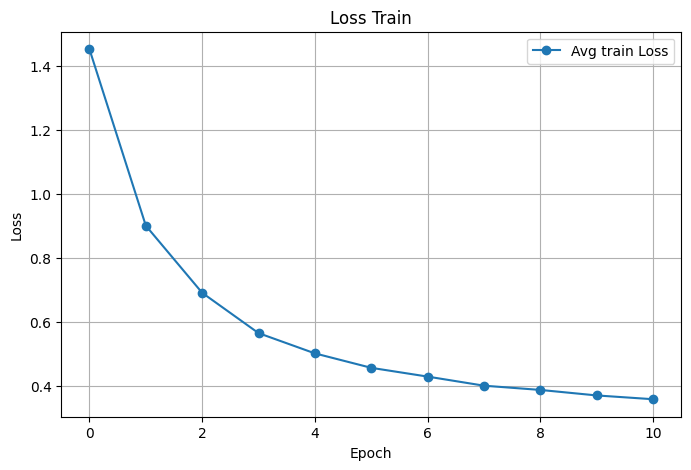

In [ ]:
train_losses = np.array(train_losses)
inference_losses = np.array(inference_losses)

plt.figure(figsize=(8, 5))
plt.plot(train_losses[:, 0], train_losses[:, 1], label='Avg train Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Train")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(inference_losses[:, 0], inference_losses[:, 1], label='prediction', color='red', linestyle='--')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Eval")
plt.legend()
plt.grid(True)
plt.show()

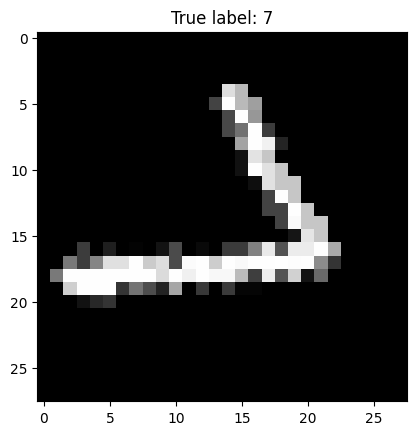

Predicted label: 7


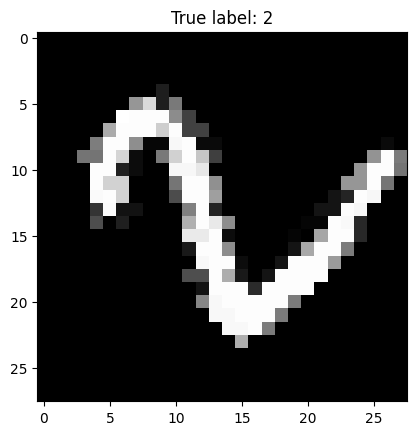

Predicted label: 2


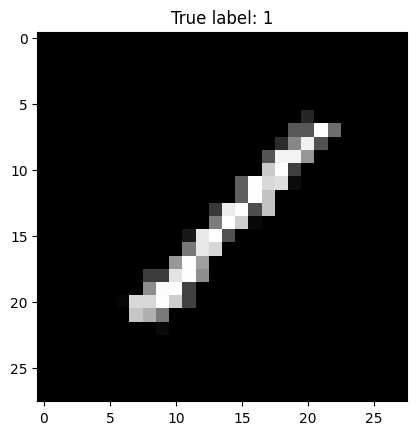

Predicted label: 1


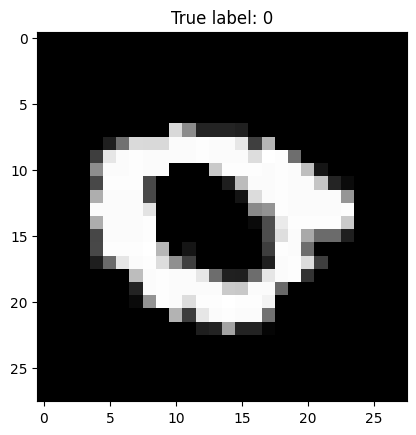

Predicted label: 0


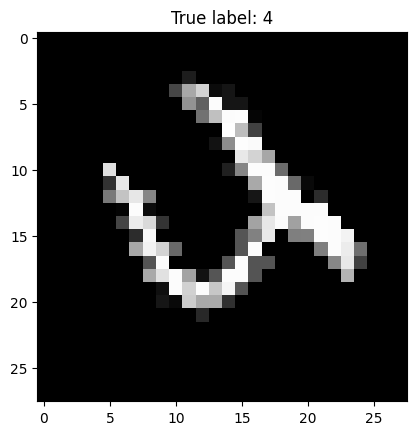

Predicted label: 4


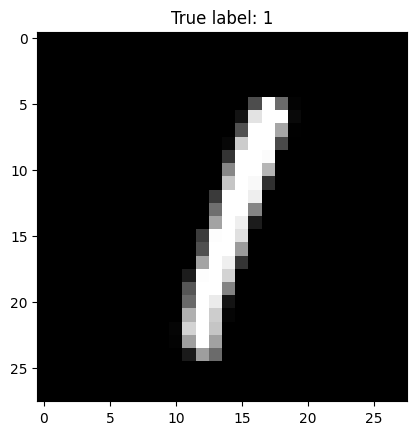

Predicted label: 1


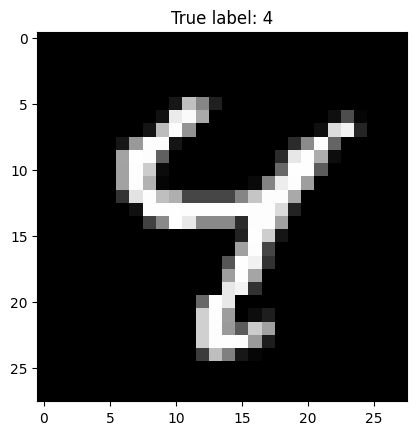

Predicted label: 4


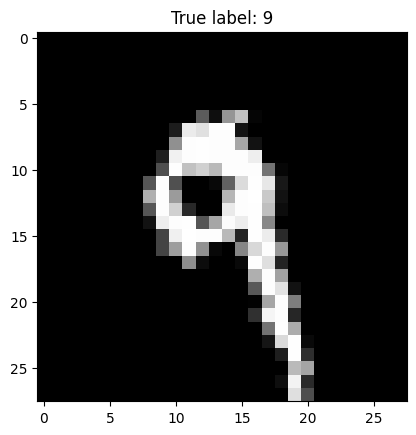

Predicted label: 9


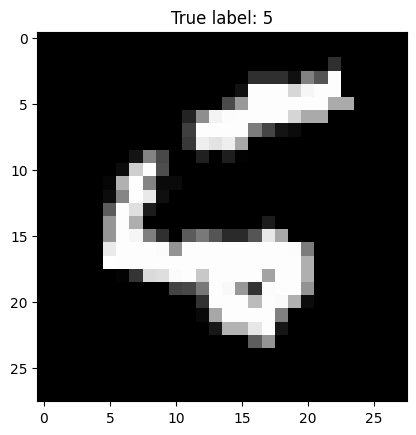

Predicted label: 6


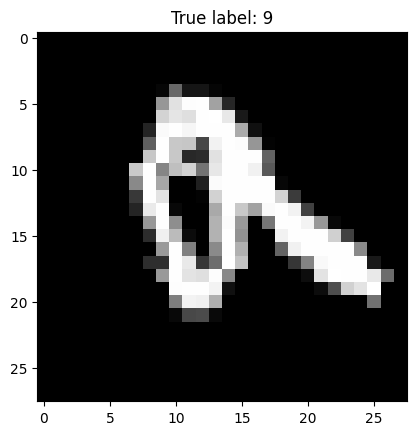

Predicted label: 9


In [14]:
x_image, y_label = next(iter(test_loader))
for i in range(10):
    plt.imshow(x_image[i].squeeze(), cmap='gray')
    plt.title(f"True label: {y_label[i]}")
    plt.show()
    input_tensor = torch.Tensor(x_image[i]).unsqueeze(0).to(config.device)
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        output = model(input_tensor)
        loss = criterion(output, torch.tensor([y_label[i]], device='cuda' if torch.cuda.is_available() else 'cpu'))
        pred_label = output.argmax(dim=1).item()
        print(f"Predicted label: {pred_label}")